In [1]:
import torch
import numpy as np

In [2]:
import torch.nn.functional as F

from torch import nn, optim

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

In [4]:
num_workers = 2

batch_size = 20

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]) 

train_data = datasets.CIFAR10(root="CIFAR10_data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="CIFAR10_data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Files already downloaded and verified


# Data visualization

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)

images, labels = dataiter.next()

images = images.numpy()

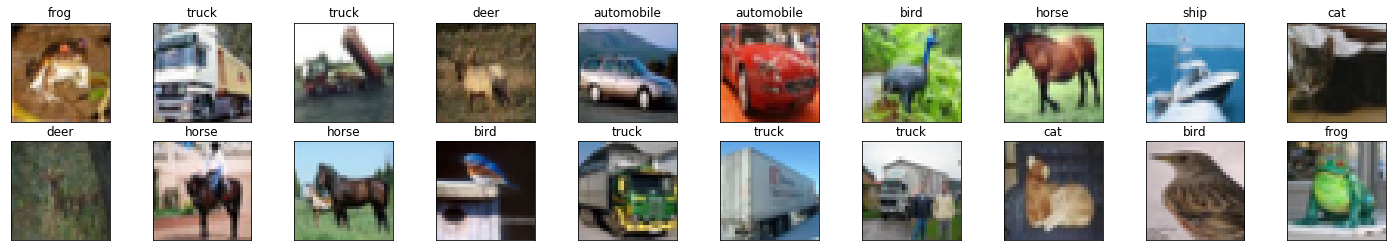

In [13]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    
    ax.set_title(str(classes[labels[idx].item()]))

# Define the network

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(0.2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # flatten
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.log_softmax(self.fc2(x))
        
        return x

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (log_softmax): LogSoftmax()
)


In [16]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the network

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
n_epochs = 30

model.to(device)

for epoch in range(n_epochs):
    train_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {}: Training loss {:.6f}".format(epoch, train_loss))

Epoch 0: Training loss 0.447888
Epoch 1: Training loss 0.421314
Epoch 2: Training loss 0.392035
Epoch 3: Training loss 0.375582
Epoch 4: Training loss 0.352825
Epoch 5: Training loss 0.334843
Epoch 6: Training loss 0.318855
Epoch 7: Training loss 0.306172
Epoch 8: Training loss 0.290441
Epoch 9: Training loss 0.272488
Epoch 10: Training loss 0.266437
Epoch 11: Training loss 0.254566
Epoch 12: Training loss 0.245899
Epoch 13: Training loss 0.236348
Epoch 14: Training loss 0.227432
Epoch 15: Training loss 0.219194
Epoch 16: Training loss 0.210295
Epoch 17: Training loss 0.198814
Epoch 18: Training loss 0.193326
Epoch 19: Training loss 0.187500
Epoch 20: Training loss 0.186176
Epoch 21: Training loss 0.175975
Epoch 22: Training loss 0.172549
Epoch 23: Training loss 0.165789
Epoch 24: Training loss 0.168030
Epoch 25: Training loss 0.163812
Epoch 26: Training loss 0.158026
Epoch 27: Training loss 0.152358
Epoch 28: Training loss 0.149906
Epoch 29: Training loss 0.147679


# Test the network

In [27]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    #!Important: Change model to evaluation mode to deactivate dropout
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
                
        output = model(data)
        
        loss = criterion(output, target)
        
        test_loss += loss.item() * data.size(0)
        
        output = torch.exp(output)
        _, pred = torch.max(output, 1)
        
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    #!Important: Change model to training mode to activate dropout
    model.train()



In [28]:
test_loss = test_loss / len(test_loader.dataset)
print("Test loss: {:.3f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test loss: 1.005

Test Accuracy of     0: 77% (776/1000)
Test Accuracy of     1: 85% (855/1000)
Test Accuracy of     2: 63% (632/1000)
Test Accuracy of     3: 63% (634/1000)
Test Accuracy of     4: 70% (700/1000)
Test Accuracy of     5: 64% (640/1000)
Test Accuracy of     6: 82% (822/1000)
Test Accuracy of     7: 84% (840/1000)
Test Accuracy of     8: 88% (880/1000)
Test Accuracy of     9: 84% (848/1000)

Test Accuracy (Overall): 76% (7627/10000)


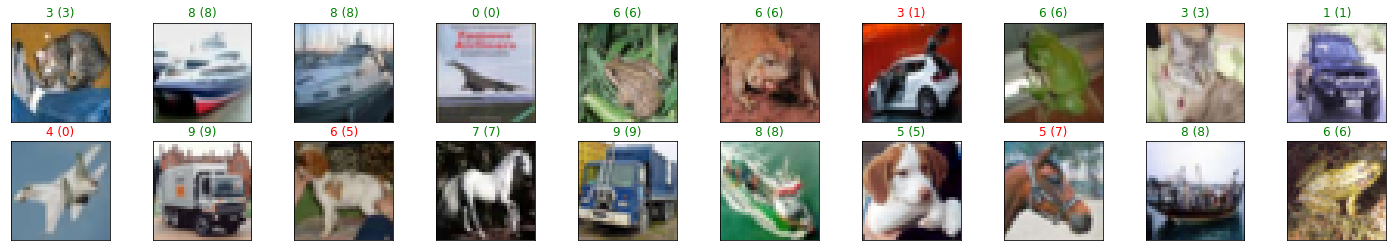

In [29]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))